# Analyse bivariée: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




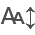

In [5]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [6]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [7]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [8]:
## define SPARQL enpoint
endpoint = "https://ag1z2eharc0r3drq.allegrograph.cloud/repositories/F1Drivers"

In [9]:
query = """
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>

SELECT
  ?personUri
  (SAMPLE(?personLabel) AS ?personLabel)
  (xsd:integer(SUBSTR(STR(SAMPLE(?birthDate)),1,4)) AS ?birthYear)
  (GROUP_CONCAT(DISTINCT ?genderLabel;   separator=", ") AS ?genderLabels)
  (GROUP_CONCAT(DISTINCT ?countryLabel;  separator=", ") AS ?countryLabels)
  (GROUP_CONCAT(DISTINCT ?continentLabel;separator=", ") AS ?continentLabels)
  (GROUP_CONCAT(DISTINCT ?occLabel;      separator=", ") AS ?occLabels)
WHERE {
  GRAPH <https://github.com/Benmad26/Formula1_drivers/blob/main/graphs/wikidata-imported-data.md> {
    ?personUri a wd:Q5.

    OPTIONAL { ?personUri rdfs:label ?personLabel. }
    OPTIONAL { ?personUri wdt:P569 ?birthDate. }

    OPTIONAL {
      ?personUri wdt:P21 ?g.
      ?g rdfs:label ?genderLabel.
    }
    OPTIONAL {
      ?personUri wdt:P27 ?country.
      ?country rdfs:label ?countryLabel.
      ?country wdt:P30 ?continent.
      ?continent rdfs:label ?continentLabel.
    }
    OPTIONAL {
      ?personUri wdt:P106 ?occ.
      ?occ rdfs:label ?occLabel.
    }
  }
}
GROUP BY ?personUri


"""

In [10]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [11]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

1057


[['http://www.wikidata.org/entity/Q439288',
  'Gary Brabham',
  '1961',
  'male',
  'Australia',
  'Oceania',
  'Formula One driver, racing automobile driver'],
 ['http://www.wikidata.org/entity/Q978791',
  'Rodolfo González',
  '1986',
  'male',
  'Venezuela',
  'South America',
  'Formula One driver, racing automobile driver'],
 ['http://www.wikidata.org/entity/Q173001',
  'David Brabham',
  '1965',
  'male',
  'Australia',
  'Oceania',
  'Formula One driver, racing automobile driver']]

In [12]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver"
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver"
2,http://www.wikidata.org/entity/Q173001,David Brabham,1965,male,Australia,Oceania,"Formula One driver, racing automobile driver"
3,http://www.wikidata.org/entity/Q7441028,Sean Gelael,1996,male,Indonesia,Asia,"Formula Two driver, Formula One driver, racing..."
4,http://www.wikidata.org/entity/Q173455,Brian Hart,1936,male,United Kingdom,Europe,"Formula One driver, engineer"


In [13]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [14]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057 entries, 0 to 1056
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    1057 non-null   object
 1   personLabel  1057 non-null   object
 2   birthYear    1057 non-null   int64 
 3   gender       1057 non-null   object
 4   countries    1057 non-null   object
 5   continents   1057 non-null   object
 6   occupations  1057 non-null   object
dtypes: int64(1), object(6)
memory usage: 57.9+ KB


In [20]:
### Store to CSV
import os
os.makedirs('Data', exist_ok=True)
df_p.to_csv('Data/df_continent_occupations_fields_2025.csv', index=False)

## Coder les continents et afficher leur distribution

In [21]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0          Oceania
1    South America
2          Oceania
3             Asia
4           Europe
Name: continents, dtype: object


In [22]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                                                  0
continents                                         
Europe                                          599
North America                                   271
South America                                    68
Asia                                             37
Africa                                           30
Oceania                                          17
                                                  9
Oceania, Australian continent, Insular Oceania    8
Europe, North America                             7
South America, Europe                             3


In [23]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [24]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [25]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver",SouthAmerica
2,http://www.wikidata.org/entity/Q173001,David Brabham,1965,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania


In [26]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Eurasia              3
Missing              9
Oceania             27
Africa              30
Asia                37
SouthAmerica        68
NorthAmerica       272
Europe             611


In [27]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode
122,http://www.wikidata.org/entity/Q544206,Sergey Sirotkin,1995,male,Russia,Europe,"Formula One driver, racing automobile driver",Europe
140,http://www.wikidata.org/entity/Q979668,Daniil Kvyat,1994,male,Russia,Europe,"Formula One driver, racing automobile driver",Europe
370,http://www.wikidata.org/entity/Q22008968,Nikita Mazepin,1999,male,Russia,Europe,"Formula One driver, racing automobile driver",Europe
462,http://www.wikidata.org/entity/Q82901,Vitaly Petrov,1984,male,Russia,Europe,"Formula One driver, racing automobile driver",Europe
897,http://www.wikidata.org/entity/Q14924659,Artem Markelov,1994,male,Russia,Europe,"Formula One driver, racing automobile driver, ...",Europe
967,http://www.wikidata.org/entity/Q27899203,Robert Shwartzman,1999,male,"Russia, Israel","Europe, Asia","Formula One driver, racing automobile driver",Eurasia


In [28]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Eurasia          1
Europe           5


In [29]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode
97,http://www.wikidata.org/entity/Q171462,Jean-Pierre Jabouille,1942,male,France,Europe,"Formula One driver, racing automobile driver, ...",Europe
98,http://www.wikidata.org/entity/Q781643,Ockelbo-Lundgren,1919,male,Sweden,Europe,"Formula One driver, racing automobile driver, ...",Europe
99,http://www.wikidata.org/entity/Q2232584,Roy Sherman,1909,male,United States,North America,Formula One driver,NorthAmerica
100,http://www.wikidata.org/entity/Q173195,Alberto Uria,1924,male,Uruguay,South America,"Formula One driver, racing automobile driver, ...",SouthAmerica


In [30]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode
111,http://www.wikidata.org/entity/Q172231,Renzo Zorzi,1946,male,Italy,Europe,"Formula One driver, racing automobile driver",Europe
112,http://www.wikidata.org/entity/Q171786,Jo Schlesser,1928,male,France,Europe,"Formula One driver, racing automobile driver, ...",Europe
113,http://www.wikidata.org/entity/Q172546,William Cantrell,1908,male,United States,North America,"Formula One driver, racing driver",NorthAmerica
114,http://www.wikidata.org/entity/Q172821,John James,1914,male,United Kingdom,Europe,"Formula One driver, engineer",Europe
115,http://www.wikidata.org/entity/Q2189587,David Clapham,1931,male,South Africa,Africa,"Formula One driver, journalist, racing driver,...",Africa
116,http://www.wikidata.org/entity/Q173686,Jack Turner,1920,male,United States,North America,"Formula One driver, racing driver, engineer",NorthAmerica
117,http://www.wikidata.org/entity/Q61917,Giorgio Pantano,1979,male,Italy,Europe,"Formula One driver, racing automobile driver",Europe


In [31]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("astronomer|physicist"))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  1057 

0    http://www.wikidata.org/entity/Q439288
1    http://www.wikidata.org/entity/Q978791
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver",SouthAmerica
2,http://www.wikidata.org/entity/Q173001,David Brabham,1965,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania
3,http://www.wikidata.org/entity/Q7441028,Sean Gelael,1996,male,Indonesia,Asia,"Formula Two driver, Formula One driver, racing...",Asia
4,http://www.wikidata.org/entity/Q173455,Brian Hart,1936,male,United Kingdom,Europe,"Formula One driver, engineer",Europe


### Distribution des continents: représentation graphique

In [32]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Eurasia,3,0.28
Missing,9,0.85
Oceania,27,2.55
Africa,30,2.84
Asia,37,3.50
SouthAmerica,68,6.43
NorthAmerica,272,25.73
Europe,611,57.81


In [33]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,Europe,NorthAmerica,SouthAmerica,Asia,Africa,Oceania,Missing,Eurasia
frequence,57.81,25.73,6.43,3.5,2.84,2.55,0.85,0.28


In [35]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#E7DDFF",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


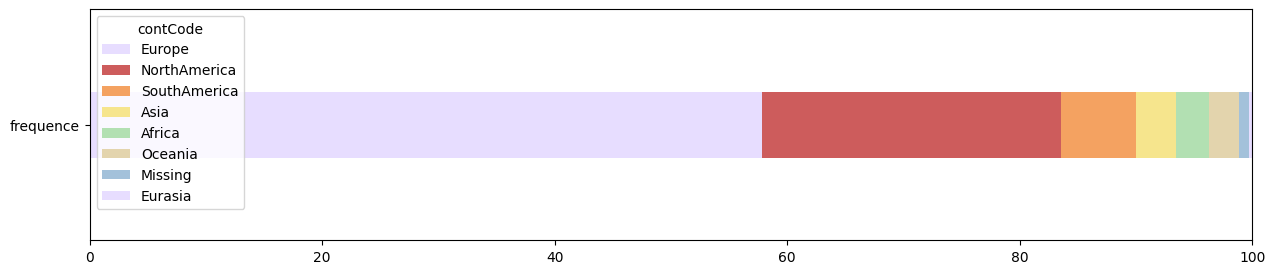

In [36]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [37]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [38]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [39]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode,per_25
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver",SouthAmerica,1976-2000
2,http://www.wikidata.org/entity/Q173001,David Brabham,1965,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975


In [40]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1876-1900     11
1901-1925    346
1926-1950    389
1951-1975    177
1976-2000    134
dtype: int64


### Comparer période et continent

In [41]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,Missing,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,,
1876-1900,0,0,0,11,0,0,0,0,11
1901-1925,4,1,1,156,6,156,2,20,346
1926-1950,24,5,0,229,3,97,17,14,389
1951-1975,2,15,0,128,0,8,4,20,177
1976-2000,0,16,2,87,0,11,4,14,134
Total,30,37,3,611,9,272,27,68,1057


In [42]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'Missing', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1876-1900,11,0,0,0,0,0,0,11
1901-1925,156,1,156,1,4,2,20,346
1926-1950,229,0,97,5,24,17,14,389
1951-1975,128,0,8,15,2,4,20,177
1976-2000,87,2,11,16,0,4,14,134
Total,611,3,272,37,30,27,68,1057


In [43]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#E7DDFF",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


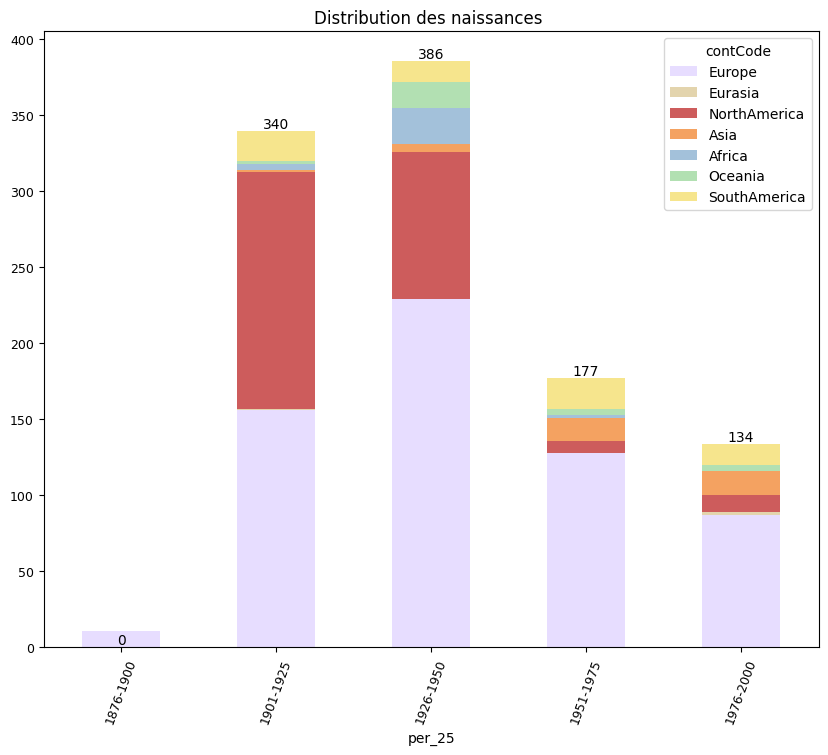

In [46]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances ')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])
plt.savefig('images/Distributiondesnaissances.jpg', bbox_inches='tight',
                       pad_inches=0.2)


plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [47]:
ddf

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1876-1900,11,0,0,0,0,0,0,11
1901-1925,156,1,156,1,4,2,20,346
1926-1950,229,0,97,5,24,17,14,389
1951-1975,128,0,8,15,2,4,20,177
1976-2000,87,2,11,16,0,4,14,134
Total,611,3,272,37,30,27,68,1057


In [48]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[3:10,:-1].copy(deep=True)
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1951-1975,128,0,8,15,2,4,20
1976-2000,87,2,11,16,0,4,14
Total,611,3,272,37,30,27,68


In [49]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 3 , 7 ), effectif: 1359 , nombre max. facteurs: 2


In [50]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 89.02 , dof : 12
p-value : 7.645615687361222e-14
phi2 = inertie (variance totale) : 0.06550283385910809
Cramer:  0.18097352549352086


In [51]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1951-1975,108,1,38,9,4,5,13
1976-2000,81,0,29,7,3,3,10
Total,637,4,224,52,25,27,79


In [52]:
D

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1951-1975,128,0,8,15,2,4,20
1976-2000,87,2,11,16,0,4,14
Total,611,3,272,37,30,27,68


In [53]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1951-1975      20       -1           -30     6      -2       -1             7
1976-2000       6        2           -18     9      -3        1             4
Total         -26       -1            48   -15       5        0           -11


In [54]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1951-1975,1.97,-0.81,-4.86,2.06,-1.06,-0.26,1.84
1976-2000,0.62,2.15,-3.30,3.59,-1.78,0.30,1.24
Total,-1.03,-0.44,3.18,-2.13,1.07,0.00,-1.20


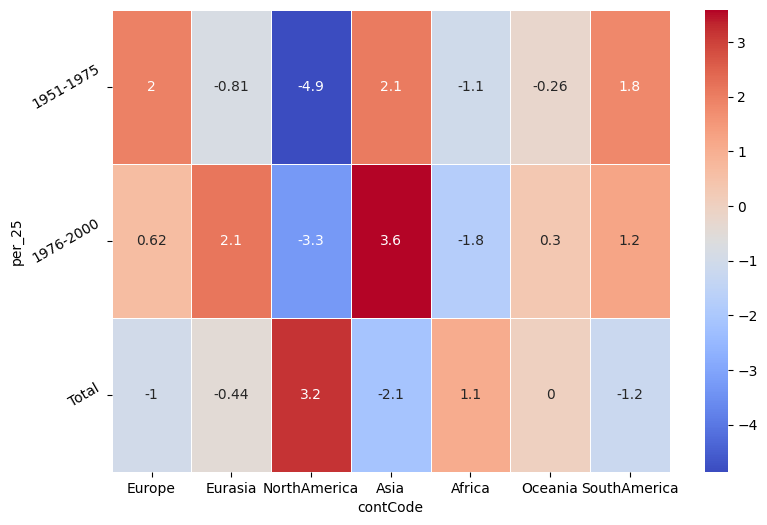

In [56]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)
plt.savefig('images/heatmap.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()



### En excluant l'Europe ou choisissant les pays

In [57]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1951-1975,0,8,15,2,4,20
1976-2000,2,11,16,0,4,14
Total,3,272,37,30,27,68


In [58]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 89.67 , dof : 10
p-value : 6.219383342676101e-15
phi2 = inertie (variance totale) : 0.06598424320127462
Cramer:  0.29003555858618735


In [59]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1951-1975,128,15,0,8,20
1976-2000,87,16,2,11,14
Total,611,37,3,272,68


In [60]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

Chi2 : 4.94 , dof : 2
p-value : 0.08477473152764486
phi2 = inertie (variance totale) : 0.0036317259129605086
Cramer:  0.07706652006349547


## Continent et genre

In [61]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode,per_25
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver",SouthAmerica,1976-2000
2,http://www.wikidata.org/entity/Q173001,David Brabham,1965,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975
3,http://www.wikidata.org/entity/Q7441028,Sean Gelael,1996,male,Indonesia,Asia,"Formula Two driver, Formula One driver, racing...",Asia,1976-2000
4,http://www.wikidata.org/entity/Q173455,Brian Hart,1936,male,United Kingdom,Europe,"Formula One driver, engineer",Europe,1926-1950


In [62]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,Missing,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,,
female,1,0,0,5,0,0,0,0,6
male,29,37,3,606,9,272,27,68,1051
Total,30,37,3,611,9,272,27,68,1057


### Créer la fonction

In [63]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [64]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,Missing,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,,
female,1,0,0,5,0,0,0,0
male,29,37,3,606,9,272,27,68


Chi2 : 7.12 , dof : 7
p-value : 0.4164145245551956
phi2 = inertie (variance totale) : 0.005239714220354071
Cramer:  0.08207786197367424


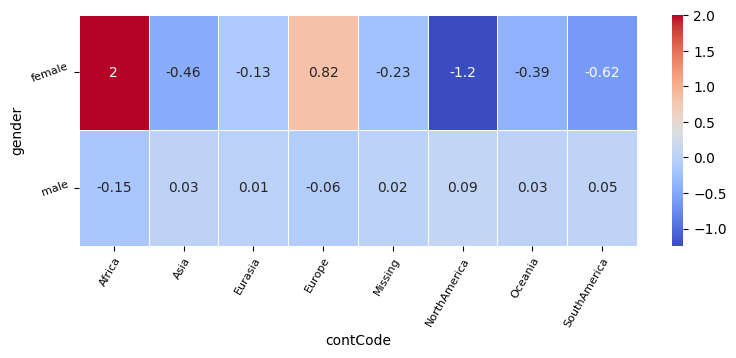

In [65]:
bivariee_stats(D)

### Genre et continent par époque

In [66]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975,Oceania_male
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver",SouthAmerica,1976-2000,SouthAmerica_male
2,http://www.wikidata.org/entity/Q173001,David Brabham,1965,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975,Oceania_male
3,http://www.wikidata.org/entity/Q7441028,Sean Gelael,1996,male,Indonesia,Asia,"Formula Two driver, Formula One driver, racing...",Asia,1976-2000,Asia_male
4,http://www.wikidata.org/entity/Q173455,Brian Hart,1936,male,United Kingdom,Europe,"Formula One driver, engineer",Europe,1926-1950,Europe_male


In [70]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_female,Africa_male,Asia_male,Eurasia_male,Europe_female,Europe_male,Missing_male,NorthAmerica_male,Oceania_male,SouthAmerica_male,Total
per_25,,,,,,,,,,,
1876-1900,0,0,0,0,0,11,0,0,0,0,11
1901-1925,0,4,1,1,0,156,6,156,2,20,346
1926-1950,0,24,5,0,3,226,3,97,17,14,389
1951-1975,1,1,15,0,1,127,0,8,4,20,177
1976-2000,0,0,16,2,1,86,0,11,4,14,134
Total,1,29,37,3,5,606,9,272,27,68,1057


In [85]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[0:-1,:-1].copy(deep=True)
D


genre_cont,Africa_female,Africa_male,Asia_male,Eurasia_male,Europe_female,Europe_male,Missing_male,NorthAmerica_male,Oceania_male,SouthAmerica_male
per_25,,,,,,,,,,
1876-1900,0,0,0,0,0,11,0,0,0,0
1901-1925,0,4,1,1,0,156,6,156,2,20
1926-1950,0,24,5,0,3,226,3,97,17,14
1951-1975,1,1,15,0,1,127,0,8,4,20
1976-2000,0,0,16,2,1,86,0,11,4,14


Chi2 : 251.52 , dof : 36
p-value : 3.85342269523507e-34
phi2 = inertie (variance totale) : 0.18508076938765236
Cramer:  0.2439062264542953


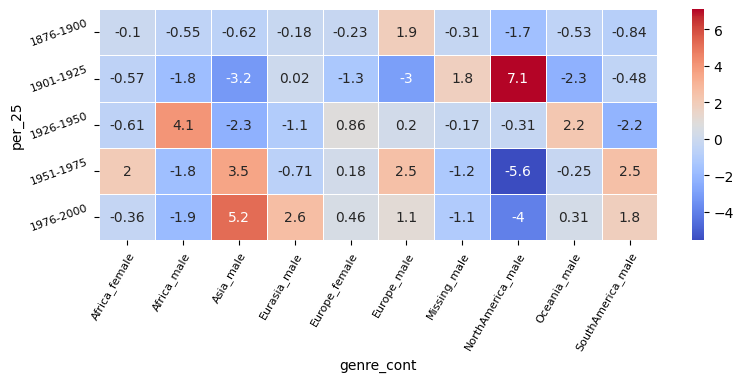

In [86]:
## Appliquer la fonction
bivariee_stats(D)

#### Explorer les résultats et commenter

In [87]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

5


In [88]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
Italy                      2
United Kingdom             2
Kingdom of Italy, Italy    1
dtype: int64


In [89]:
print(df_pef[df_pef.per_25 == '1976-2000'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
United Kingdom    1
dtype: int64


In [76]:
fff = df_pef[(df_pef.per_25 == '1976-2000') & (df_pef.countries.str.contains('Germany'))]
print(len(fff))
fff.head()

0


,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode,per_25,genre_cont


## Continent et discipline

In [77]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975,Oceania_male
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver",SouthAmerica,1976-2000,SouthAmerica_male
2,http://www.wikidata.org/entity/Q173001,David Brabham,1965,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975,Oceania_male
3,http://www.wikidata.org/entity/Q7441028,Sean Gelael,1996,male,Indonesia,Asia,"Formula Two driver, Formula One driver, racing...",Asia,1976-2000,Asia_male
4,http://www.wikidata.org/entity/Q173455,Brian Hart,1936,male,United Kingdom,Europe,"Formula One driver, engineer",Europe,1926-1950,Europe_male


In [123]:
def code_discipline(col1):
    if  'racing automobile driver' in col1\
        or 'Formula Two driver' in col1:
        output = 'driver'
    elif 'sports commentator' in col1\
        or ' television presenter' in col1:
        output = 'TV presenter'
    else:
        output = 'other'
    return output    


In [124]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975,Oceania_male,driver
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver",SouthAmerica,1976-2000,SouthAmerica_male,driver
2,http://www.wikidata.org/entity/Q173001,David Brabham,1965,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975,Oceania_male,driver
3,http://www.wikidata.org/entity/Q7441028,Sean Gelael,1996,male,Indonesia,Asia,"Formula Two driver, Formula One driver, racing...",Asia,1976-2000,Asia_male,driver
4,http://www.wikidata.org/entity/Q173455,Brian Hart,1936,male,United Kingdom,Europe,"Formula One driver, engineer",Europe,1926-1950,Europe_male,other


In [125]:
df_p.groupby('code_discipline').size()

code_discipline
TV presenter      3
driver          643
other           411
dtype: int64

In [126]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,Missing,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,,
TV presenter,0,0,0,3,0,0,0,0,3
driver,14,36,2,414,2,86,23,66,643
other,16,1,1,194,7,186,4,2,411
Total,30,37,3,611,9,272,27,68,1057


In [127]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,Missing,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,,
TV presenter,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,100.0
driver,2.2,5.6,0.3,64.4,0.3,13.4,3.6,10.3,100.0
other,3.9,0.2,0.2,47.2,1.7,45.3,1.0,0.5,100.0
Total,2.8,3.5,0.3,57.8,0.9,25.7,2.6,6.4,100.0


In [128]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#E7DDFF",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


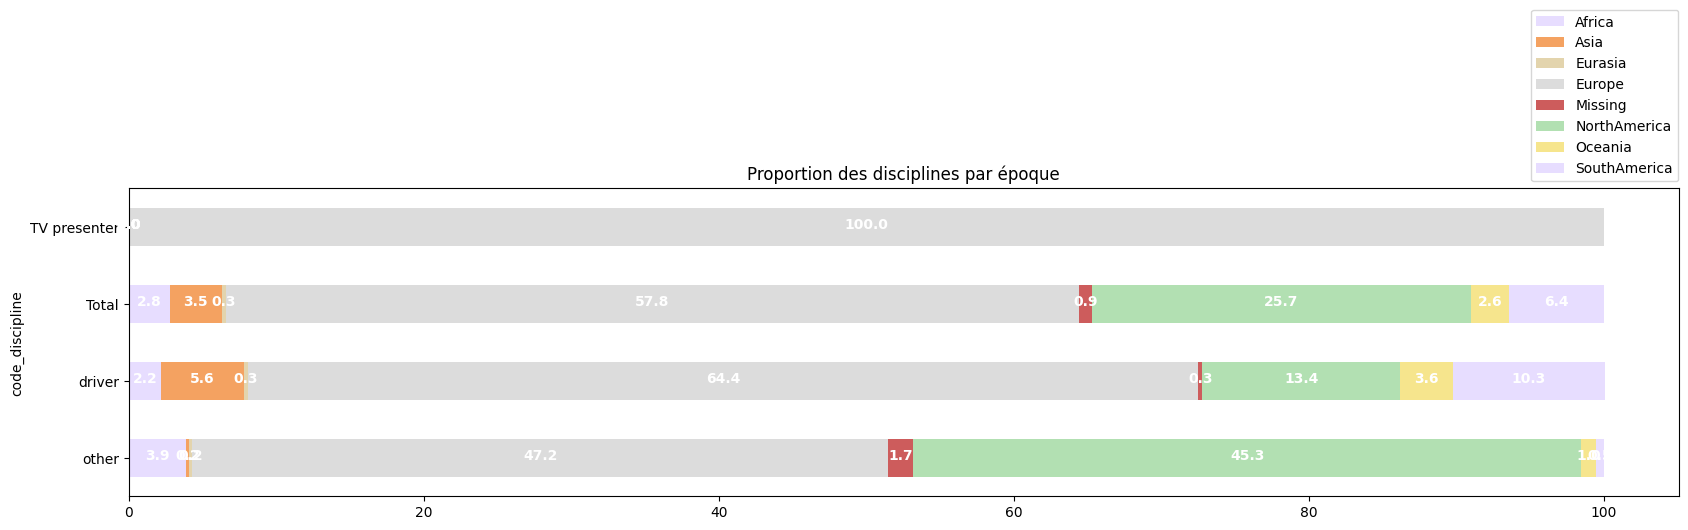

In [129]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,4), title='Proportion des disciplines par époque',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [130]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:5,:10].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,Missing,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,,
TV presenter,0,0,0,3,0,0,0,0,3
driver,14,36,2,414,2,86,23,66,643
other,16,1,1,194,7,186,4,2,411
Total,30,37,3,611,9,272,27,68,1057


Chi2 : 186.84 , dof : 24
p-value : 3.589992408093404e-27
phi2 = inertie (variance totale) : 0.13748544479272648
Cramer:  0.12136961469267861


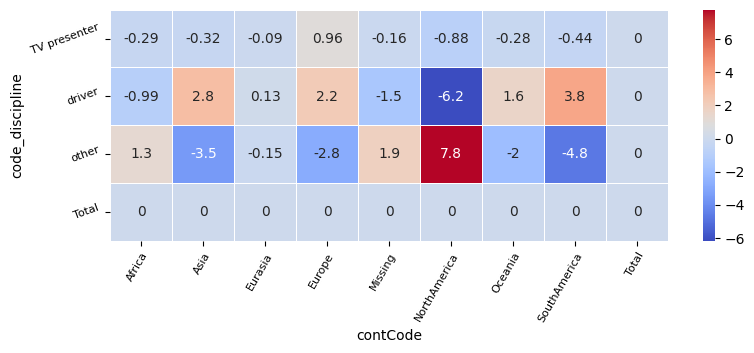

In [131]:
## Appliquer la fonction
bivariee_stats(D)

## Discipline et continent par époque

In [132]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975,Oceania_male,driver
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver",SouthAmerica,1976-2000,SouthAmerica_male,driver


In [133]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q439288,Gary Brabham,1961,male,Australia,Oceania,"Formula One driver, racing automobile driver",Oceania,1951-1975,Oceania_male,driver,Oceania_driver
1,http://www.wikidata.org/entity/Q978791,Rodolfo González,1986,male,Venezuela,South America,"Formula One driver, racing automobile driver",SouthAmerica,1976-2000,SouthAmerica_male,driver,SouthAmerica_driver


In [134]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_driver,Africa_other,Asia_driver,Asia_other,Eurasia_driver,Eurasia_other,Europe_TV presenter,Europe_driver,Europe_other,Missing_driver,Missing_other,NorthAmerica_driver,NorthAmerica_other,Oceania_driver,Oceania_other,SouthAmerica_driver,SouthAmerica_other,Total
per_25,,,,,,,,,,,,,,,,,,
1876-1900,0,0,0,0,0,0,0,9,2,0,0,0,0,0,0,0,0,11
1901-1925,3,1,1,0,0,1,0,96,60,2,4,38,118,2,0,20,0,346
1926-1950,9,15,5,0,0,0,0,132,97,0,3,35,62,13,4,13,1,389
1951-1975,2,0,15,0,0,0,3,101,24,0,0,4,4,4,0,19,1,177
1976-2000,0,0,15,1,2,0,0,76,11,0,0,9,2,4,0,14,0,134
Total,14,16,36,1,2,1,3,414,194,2,7,86,186,23,4,66,2,1057


In [138]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[1:-1,:-1].copy(deep=True)
D


disc_cont,Africa_driver,Africa_other,Asia_driver,Asia_other,Eurasia_driver,Eurasia_other,Europe_TV presenter,Europe_driver,Europe_other,Missing_driver,Missing_other,NorthAmerica_driver,NorthAmerica_other,Oceania_driver,Oceania_other,SouthAmerica_driver,SouthAmerica_other
per_25,,,,,,,,,,,,,,,,,
1901-1925,3,1,1,0,0,1,0,96,60,2,4,38,118,2,0,20,0
1926-1950,9,15,5,0,0,0,0,132,97,0,3,35,62,13,4,13,1
1951-1975,2,0,15,0,0,0,3,101,24,0,0,4,4,4,0,19,1
1976-2000,0,0,15,1,2,0,0,76,11,0,0,9,2,4,0,14,0


Chi2 : 320.87 , dof : 48
p-value : 5.010049319341159e-42
phi2 = inertie (variance totale) : 0.23610818297457306
Cramer:  0.31977078144335885


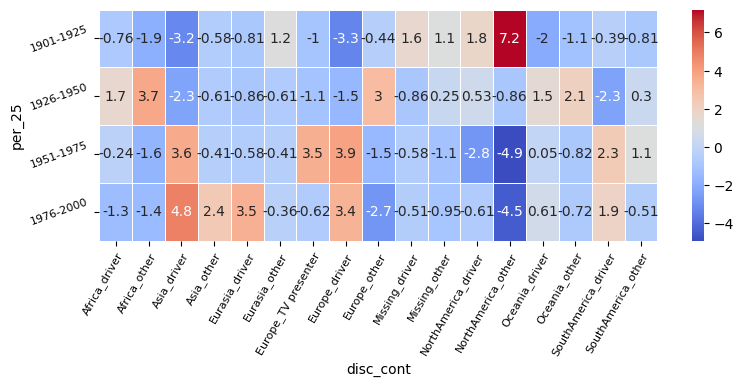

In [139]:
## Appliquer la fonction
bivariee_stats(D)